In [1]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.animation as animation
warnings.filterwarnings('ignore')
from src.data_processing.fetch_data import fetch_data_subgraph
from src.models.liquidity_distribution import LiquidityAnalyzer, Pool, LiquidityPeriphery
from src.models.backtest import LiquidityProvisionBacktester
pd.set_option("display.max_columns",100)
%load_ext autoreload
%autoreload 2

POOLS = [
    (3, "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8", "v3 USDC/ETH 0.3%", ),
    (3, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", "v3 USDC/ETH 0.05%", ),
]
API_KEY = "893d7471304c5edf436c8ba60781762c"
POOL_ADDRESS = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640".lower()
START_DATE = date(2024, 8, 1)
END_DATE = date(2024, 9, 1)
pool_query = """query get_pools($pool_id: ID!) {
  pools(where: {id: $pool_id}) {
    tick
    sqrtPrice
    liquidity
    feeTier
    totalValueLockedUSD
    totalValueLockedETH
    token0 {
      symbol
      decimals
    }
    token1 {
      symbol
      decimals
    }
  }
}"""
# POOL_ADDRESS = "0xc7bBeC68d12a0d1830360F8Ec58fA599bA1b0e9b".lower()
variables = {'pool_id': POOL_ADDRESS}
data_pool = fetch_data_subgraph(API_KEY, pool_query, variables, data_key='pools', first_n=100, batch_size=1000)[0]
pool = Pool(pool_address=POOL_ADDRESS,
            token0=data_pool['token0']['symbol'],
            token1=data_pool['token1']['symbol'],
            decimals0=data_pool['token0']['decimals'],
            decimals1=data_pool['token1']['decimals'],
            fee_tier=data_pool['feeTier'],
            sqrt_price_x96=data_pool["sqrtPrice"])

Fetched 1 records


In [2]:
# Example usage
print(pool.token0, pool.token1)
df_liquidity = pd.read_parquet(
        "/Users/gnapsamuel/Documents/AMM/proteus-LP-backtesting/data/liquidity_data.parquet"
    )


USDC WETH


In [4]:
initial_capital_amount_0 = 1 #ETH
initial_capital_amount_1 = float(df_liquidity.iloc[0]['active_price_inverted'])
initial_capital_USD = initial_capital_amount_0*(initial_capital_amount_1/initial_capital_amount_0) + initial_capital_amount_1
tick_range = 50
rebalance_cost = 0.0001

In [5]:
current_tick = int(df_liquidity.iloc[0]['active_tick_adjusted'])
lower_tick = int(current_tick - tick_range)
upper_tick = int(current_tick + tick_range)

In [6]:
liquidity_calculator = LiquidityPeriphery(pool)
sqrt_ratio_x96, sqrt_ratio_a_x96, sqrt_ratio_b_x96, amount0, amount1, liquidity = liquidity_calculator.calculate_liquidity(initial_capital_amount_0, initial_capital_amount_1, lower_tick, upper_tick, current_tick)

In [11]:
df_liquidity_s = df_liquidity.loc[df_liquidity['block_number'].isin(df_liquidity.block_number.unique()[:10])]

In [13]:
df_liquidity_s['block_number'].nunique()

10

In [15]:
df_liquidity_s

,block_number,block_timestamp,cumulative_dollar_volume,date,datetime,block,active_tick,tick,liquidity,price,amount0,amount1,amount0_real,amount1_real,active_tick_adjusted,sb,sa,active_price,active_price_inverted,amount_locked,amount_locked_USDC
0,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,198510,7.536409e+18,2394.700859,1.843444e+11,7.701861e+19,0.000000,77.018615,199010.0,198010,199010,0.000439,2277.687846,175424.363256,3.257797e+07
1,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,198520,7.537610e+18,2392.307475,1.842816e+11,7.706941e+19,0.000000,77.069413,199010.0,198020,199020,0.000439,2277.687846,175540.064970,3.257797e+07
2,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,198530,8.531228e+18,2389.916483,2.084696e+11,8.727243e+19,0.000000,87.272430,199010.0,198030,199030,0.000439,2277.687846,198779.352993,3.257797e+07
3,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,198540,8.561083e+18,2387.527880,2.090945e+11,8.762163e+19,0.000000,87.621631,199010.0,198040,199040,0.000439,2277.687846,199574.724409,3.257797e+07
4,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,198550,9.407277e+18,2385.141665,2.296470e+11,9.633048e+19,0.000000,96.330476,199010.0,198050,199050,0.000439,2277.687846,219410.754242,3.257797e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,18917177,1704167867,2.007194e+08,2024-01-02,2024-01-02 03:57:47,18917177,198538,198990,1.839546e+19,2282.475776,4.392923e+11,1.925593e+20,439292.268649,0.000000,198530.0,198490,199490,0.000419,2388.005409,439292.268649,2.274335e+07
1006,18917177,1704167867,2.007194e+08,2024-01-02,2024-01-02 03:57:47,18917177,198538,199000,1.841580e+19,2280.194555,4.395580e+11,1.928685e+20,439557.990635,0.000000,198530.0,198500,199500,0.000419,2388.005409,439557.990635,2.274335e+07
1007,18917177,1704167867,2.007194e+08,2024-01-02,2024-01-02 03:57:47,18917177,198538,199010,1.232057e+19,2277.915614,2.939269e+11,1.290978e+20,293926.884098,0.000000,198530.0,198510,199510,0.000419,2388.005409,293926.884098,2.274335e+07
1008,18917177,1704167867,2.007194e+08,2024-01-02,2024-01-02 03:57:47,18917177,198538,199020,1.196945e+19,2275.638951,2.854077e+11,1.254814e+20,285407.728576,0.000000,198530.0,198520,199520,0.000419,2388.005409,285407.728576,2.274335e+07


In [14]:
backtester = LiquidityProvisionBacktester(pool, liquidity_calculator)
results_df = backtester.backtest_liquidity_provision(df_liquidity_s,
                                                     initial_capital_USD, 
                                                     initial_capital_amount_0,
                                                     initial_capital_amount_1,
                                                     tick_range)

2024-09-29 18:59:18,921 - LiquidityProvisionBacktester - INFO - Starting backtest with 9 blocks
2024-09-29 18:59:18,921 - LiquidityProvisionBacktester - INFO - Starting backtest with 9 blocks


Error at block 18909995: name 'capital_USD' is not defined
Error at block 18911563: name 'capital_USD' is not defined
Error at block 18912951: name 'capital_USD' is not defined
Error at block 18913979: name 'capital_USD' is not defined
Error at block 18914758: name 'capital_USD' is not defined
Error at block 18915118: name 'capital_USD' is not defined
Error at block 18915921: name 'capital_USD' is not defined
Error at block 18916179: name 'capital_USD' is not defined
Error at block 18916530: name 'capital_USD' is not defined


In [1]:
from datetime import datetime, timedelta
from IPython.display import Image
from scipy.ndimage import shift
import matplotlib.pyplot as plt
from scipy.stats import cauchy
import scipy.stats as stats
from datetime import date
# from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import random
import time
import math
import warnings

warnings.filterwarnings('ignore')

In [3]:
# We take the data received using OHLC
eth_df = pd.read_csv('/Users/gnapsamuel/Documents/AMM/Uniswap-v3-backtester-Source-code-and-scripts/data/eth_1m_upd.csv')
eth_df['time'] = pd.to_datetime(eth_df['time'])
eth_df = eth_df.set_index(['time'])

# let's select a series of prices with which we will work

price_test = eth_df['close']
price_test = np.array(price_test)
swaps = pd.read_parquet("/Users/gnapsamuel/Documents/AMM/proteus-LP-backtesting/data/uniswap/USDC-WETH/fee_500/swaps/swaps_2024-01-01_to_2024-01-10.parquet")
price_test = np.array(np.float64(swaps['final_price']))

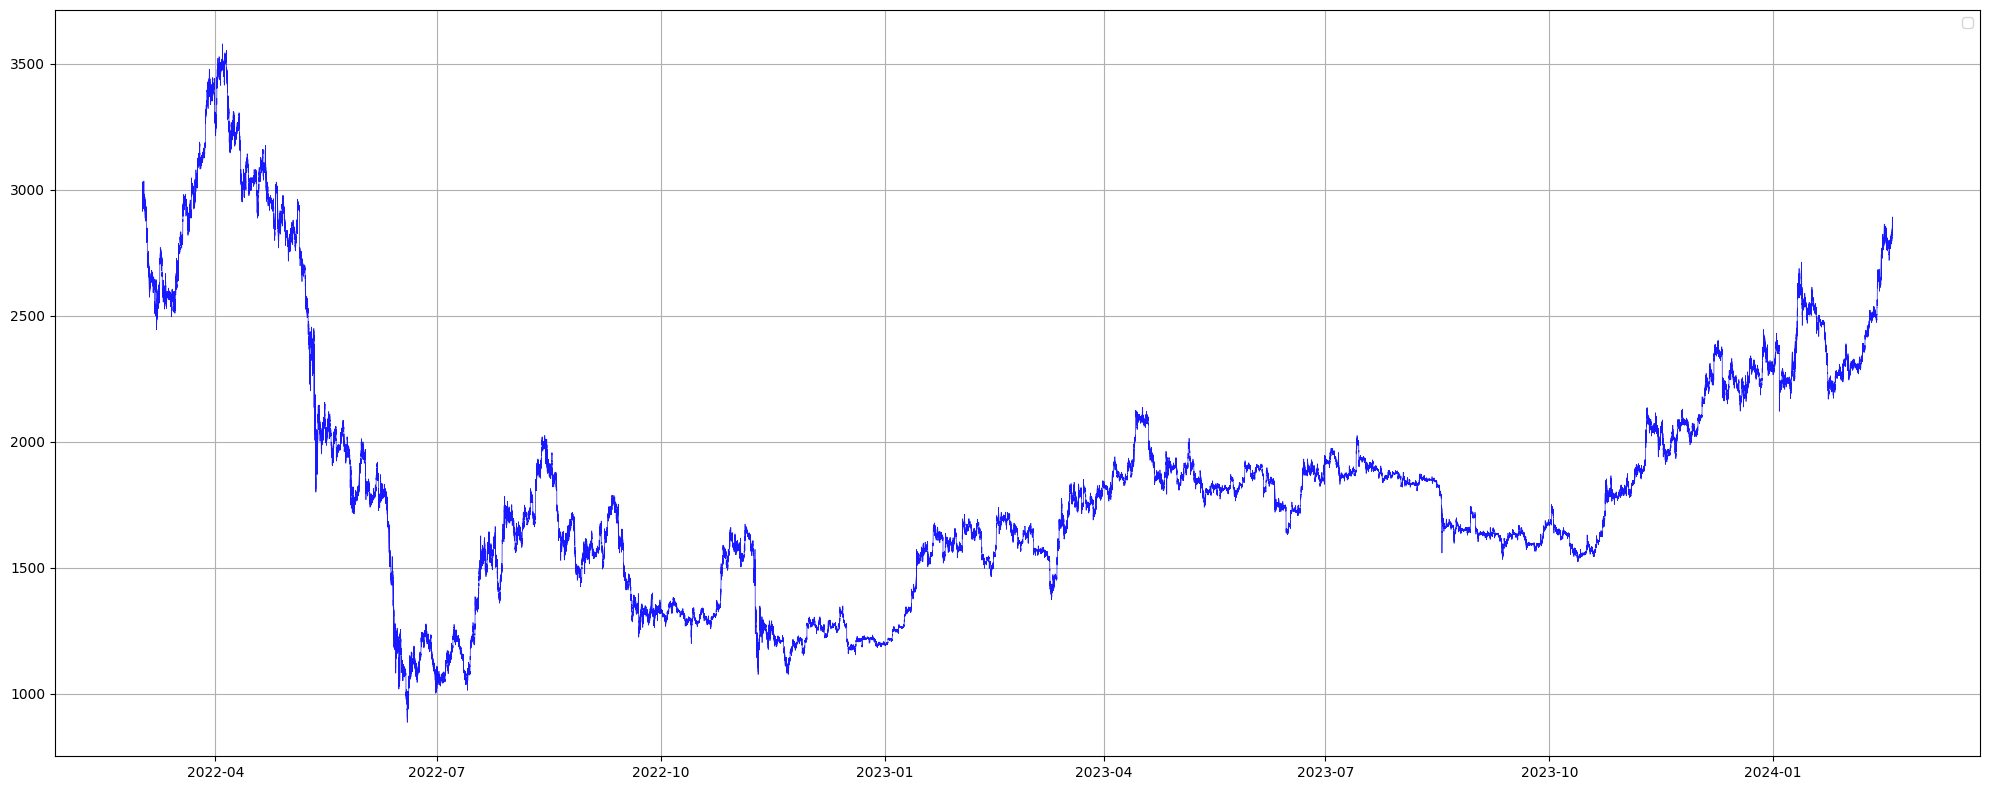

In [4]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(eth_df['close'], linewidth = 0.5, color='blue', alpha = 0.9)
legend = ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [19]:
tau = 1
price_t_up = 6
price_t_down = 1
mu_bucket = 5
scen = 10
range_prices_ = range_prices(price_t_down, price_t_up, mu_bucket)
ind_in = np.digitize(price_test, range_prices_[2], right = True)
z_moments_t = z_list_t(tau, price_test, ind_in)
scen_ar = np.zeros((scen, len(z_moments_t), mu_bucket))
scen_ar_short = np.zeros((scen, tau + 1))

In [30]:
pd.set_option('display.max_columns',100)

In [32]:
swaps.head()

,block_timestamp,block_number,transaction_hash,pool_address,event_signature,sender,recipient,tickLower,tickUpper,amount,amount0,amount1,sqrtPriceX96,liquidity,amount0Int,amount1Int,tick,price,invert_price,final_price,real_amount0,real_amount1,token_sold,amount_sold,amount_bought,dollar_value
0,2024-01-01 00:00:23+00:00,18908896,0xe74618939ea1dc797d57008f6e82aa791ee03bd564cd...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,None,None,None,700000000,-306763579689895853,1658979073488576691938403687211610,20500328755020716289,None,None,198997,0.0004384525983954719356148713893,True,2280.748257986210111962770109,700.000000,-0.306763579689895853,WETH,0.306763579689895853,700.000000000000000000,700.000000
1,2024-01-01 00:00:23+00:00,18908896,0x32c6931329b9efa707040ebe09c4bed8295acb02ef01...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,None,None,None,18096796543,-7930473657172119477,1658948424377372968220847534541264,20500328755020716289,None,None,198997,0.0004384363980002680936788183250,True,2280.832532520232326184716384,18096.796543,-7.930473657172119477,WETH,7.930473657172119477,18096.796543000000000000,18096.796543
2,2024-01-01 00:00:47+00:00,18908898,0xe429b45556e1cc5e7160864967ae9b5eb41f22eae43a...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,None,None,None,25000000000,-10955149897324132568,1658906085719939450123738796474967,20500328755020716289,None,None,198996,0.0004384140192797312965008406236,True,2280.948956976549582034943198,25000.000000,-10.955149897324132568,WETH,10.955149897324132568,25000.000000000000000000,25000.000000
3,2024-01-01 00:00:59+00:00,18908899,0x4f0cf62d1d1c5bd0820ba93c506ab34691dd820ca237...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,None,None,None,767722283,-336411657641332654,1658904785580912324867001271131668,20500328755020716289,None,None,198996,0.0004384133320811514039665263090,True,2280.952532289546111758526310,767.722283,-0.336411657641332654,WETH,0.336411657641332654,767.722283000000000000,767.722283
4,2024-01-01 00:01:23+00:00,18908901,0x3e3b95be1a79c8722a8d5f4175f2810deee8e538e522...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,None,None,None,170905965,-74889976787664771,1658904496151639139701803766491048,20500328755020716289,None,None,198996,0.0004384131791011345969435774137,True,2280.953328205757939828718570,170.905965,-0.074889976787664771,WETH,0.074889976787664771,170.905965000000000000,170.905965


In [36]:
liquidity = pd.read_parquet("liqudity.parquet")

In [37]:
liquidity.head()

,block_number,block_timestamp,cumulative_dollar_volume,date,datetime,block,active_tick,tick,liquidity,price,amount0,amount1,amount0_real,amount1_real,active_tick_adjusted,sb,sa,active_price,active_price_inverted,amount_locked
0,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192210,2.658259e+17,4496.174045,8.909607e+09,1.982588e+18,0.0,1.982588,199010.0,192180,192240,0.000439,2277.687846,4515.717620
1,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192220,2.658259e+17,4491.680343,8.905154e+09,1.983580e+18,0.0,1.983580,199010.0,192190,192250,0.000439,2277.687846,4517.975931
2,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192230,2.658259e+17,4487.191132,8.900702e+09,1.984572e+18,0.0,1.984572,199010.0,192200,192260,0.000439,2277.687846,4520.235371
3,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192240,2.658259e+17,4482.706408,8.896253e+09,1.985564e+18,0.0,1.985564,199010.0,192210,192270,0.000439,2277.687846,4522.495940
4,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192250,2.658259e+17,4478.226166,8.891807e+09,1.986557e+18,0.0,1.986557,199010.0,192220,192280,0.000439,2277.687846,4524.757641


<Axes: xlabel='datetime'>

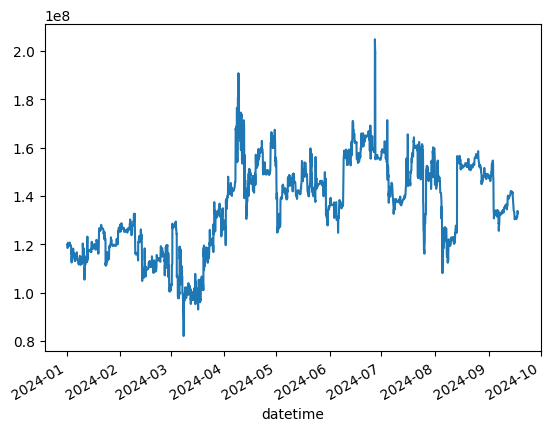

In [39]:
liquidity.groupby(by='datetime')['amount_locked'].sum().plot()

<Axes: xlabel='datetime'>

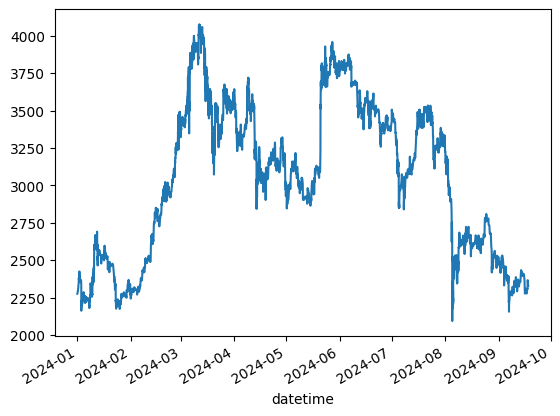

In [40]:
liquidity.groupby(by='datetime')['active_price_inverted'].min().plot()

In [41]:
z_moments_t

array([0])

In [45]:
prices = liquidity['active_price_inverted'].unique()

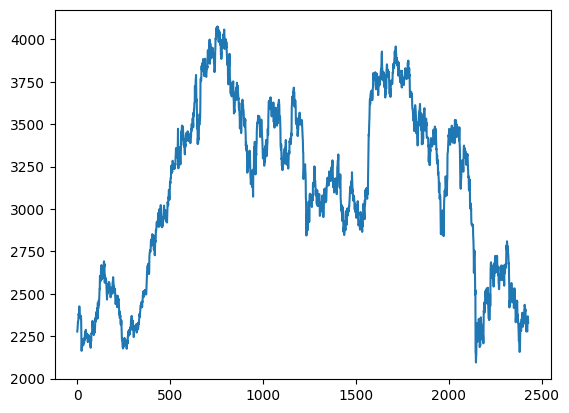

In [47]:
plt.plot(prices)

In [49]:
np.sum(np.float64(swaps['dollar_value']))

np.float64(2607789672.341052)

In [51]:
# select the mu parameter to satisfy the conditions
price_testty_ok = False

ty = 0.75
cu_pr = np.mean(prices).item()
W_initial = 100000
fact_return = np.sum(np.float64(swaps['dollar_value']))*0.0005
gas_pr = 100
tau = 100
gamma = 0.0005
price_test = prices
n_rg = 300
mu_bucket = n_rg
scen = 100
max_var = 10
min_var = 0.05
var_set = np.linspace(min_var, max_var, scen)
mu = ty
av_w = 11.5
prices_c = price_test.reshape(1, -1)
price_t_up = cu_pr + av_w * n_rg / 2
price_t_down = cu_pr - av_w * n_rg / 2
range_prices_ = range_prices(price_t_down, price_t_up, mu_bucket)

pr = prices_c[0]
ind_in = np.digitize(pr, range_prices_[2], right = True)
z_moments_t = z_list_t(tau, pr, ind_in)
t_ep = len(z_moments_t)
p0 = pr[z_moments_t]
var_ret = np.zeros((scen, 10))

k_r = 0
r_d = 3
x = np.linspace(-r_d, r_d, n_rg)

In [62]:
r_d, n_rg

(3, 300)

In [ ]:
# for t in range(scen):

In [63]:
t = 20
var = var_set[t].item()
sigma = math.sqrt(var)
var,sigma

(2.0601010101010098, 1.4353051975454592)

In [64]:
capacity = stats.norm.pdf(x, mu, sigma)

In [66]:
capacity /= np.sum(capacity)

In [67]:
xi_ar_ = np.tile(capacity, (t_ep,1))

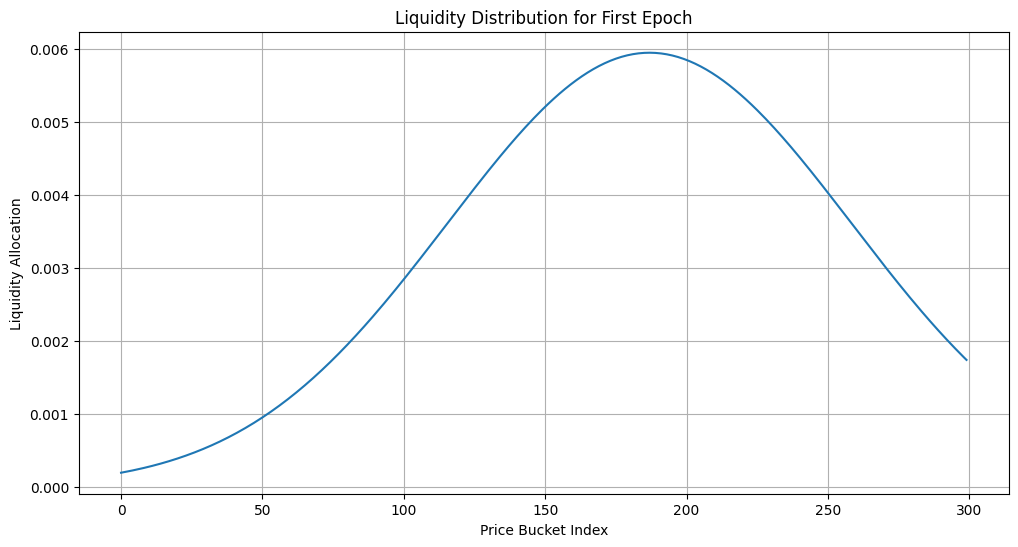

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(xi_ar_[0])), xi_ar_[0])
plt.title('Liquidity Distribution for First Epoch')
plt.xlabel('Price Bucket Index')
plt.ylabel('Liquidity Allocation')
plt.grid(True)
plt.show()

In [81]:
v3_m = v3_model(W_initial, False, gas_pr, t_ep, z_moments_t, pr, xi_ar_,
                range_prices_, ind_in, tau,
                low_memory = True, NO_cost = False, LIQ_fix = False)

In [82]:
v3_m

(np.float64(21277.30314095105),
 array([80313.94395038, 54239.73298279, 29536.59131301, 21277.30314095]),
 array([[[           nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [6.90717070e-03, 0.00000000e+00, 4.05270102e+02, 4.85202888e+03,
          4.84052888e+03, 1.00000000e+00],
         [7.16343856e-03, 0.00000000e+00, 4.18811151e+02, 4.84052888e+03,
          4.82902888e+03, 2.00000000e+00],
         ...,
         [0.00000000e+00, 1.42864803e+02, 9.36031324e+02, 1.42502888e+03,
          1.41352888e+03, 2.99000000e+02],
         [0.00000000e+00, 1.39781409e+02, 9.12111408e+02, 1.41352888e+03,
          1.40202888e+03, 3.00000000e+02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.01000000e+02]],
 
        [[           nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [6.90717070e-03, 0.00000000e+00, 4.05270102e+02, 

In [ ]:

var_ret[t,k_r] = v3_m[-5].item()

In [ ]:
k_r += 1

plt.subplots(figsize = (120, 70))
plt.plot(var_set, var_ret[:,0], lw = 10,label = ty)

plt.xticks(size = 80)
plt.yticks(size = 80)

plt.title("Returns curve", fontsize = 110)
plt.ylabel("Returns, $10m", fontsize = 80)
plt.xlabel("Variance", fontsize = 80)
plt.hlines(y = fact_return, xmin = 0, xmax = max_var,
                    colors = 'red', ls = ':', lw = 10, label = 'fact returns')
plt.show()
